# Demo Similarity - Info Measures

**Base Model**

* era5

**CMIP5 Models**:
* "inmcm4",
* "access1_0",
* "bcc_csm1_1",
* "bcc_csm1_1_m",
* "bnu_esm",
* "cnrm_cm5",
* "ec_earth",
* "fgoals_s2",
* "ipsl_cm5b_lr",
* "mpi_esm_lr",
* "mpi_esm_mr"

In [15]:
import sys, os
from pyprojroot import here

# spyder up to find the root
isp_root = "/home/emmanuel/code/isp_data"
pysim_root = "/home/emmanuel/code/pysim"
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))
sys.path.append(str(isp_root))
sys.path.append(str(pysim_root))

from pathlib import Path

#
import xarray as xr
from pprint import pprint
import cftime
import xesmf as xe
from isp_data.esdc.temporal import convert_to_360day_monthly
from src.models.univariate import pearson, knn_mutual_info_nbs, knn_mutual_info_eps, get_univariate_stats
from src.features.preprocessing import transform_data
import tqdm
import numpy as np
import pandas as pd
import itertools

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [2]:
ERA5_DIR = "/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/ERA5/REANALYSIS/ZARR"
CMIP5_DIR = "/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/CMIP5/RCP8_5/NETCDF"
VARIABLE = "mean_sea_level_pressure"
TIME_SLICE = slice("2020", "2020")
BASE_GRID_MODEL = "ipsl_cm5b_lr"


In [3]:
d_ = xr.open_zarr("/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/ERA5/REANALYSIS/ZARR/mean_sea_level_pressure/era5_reanalysis.nc")

In [4]:
!ls $ERA5_DIR

mean_sea_level_pressure


In [5]:

cmip_glob = Path(CMIP5_DIR).joinpath(VARIABLE).glob(f"*.nc")
era5_glob = Path(ERA5_DIR).joinpath(VARIABLE).glob(f"*.nc")
nc_files = [str(x) for x in cmip_glob if x.is_dir()]
nc_files = nc_files + [str(x) for x in era5_glob if x.is_dir()]

In [6]:
nc_files

['/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/CMIP5/RCP8_5/NETCDF/mean_sea_level_pressure/giss_e2_h_cc_rcp8_5.nc',
 '/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/CMIP5/RCP8_5/NETCDF/mean_sea_level_pressure/mpi_esm_lr_rcp8_5.nc',
 '/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/CMIP5/RCP8_5/NETCDF/mean_sea_level_pressure/bnu_esm_rcp8_5.nc',
 '/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/CMIP5/RCP8_5/NETCDF/mean_sea_level_pressure/access1_0_rcp8_5.nc',
 '/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/CMIP5/RCP8_5/NETCDF/mean_sea_level_pressure/access1_3_rcp8_5.nc',
 '/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/CMIP5/RCP8_5/NETCDF/mean_sea_level_pressure/noresm1_m_rcp8_5.nc',
 '/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/SIM4CLIM/CMIP5/RCP8_5/NETCDF/mean_sea_level_pressure/mpi_esm_mr_rcp8_5.nc',
 '/media/disk/databases/CLIMATE/CLIMATE_DATA_STORE/STAGING/

In [7]:
ds = {}
for ifile in nc_files:
    # manually set the encoding to use cftime

    i_ds = xr.open_zarr(ifile, decode_times=True, use_cftime=True)

    # assign a new coordinate name
    try:
        model_id = i_ds.model_id.lower().replace("-", "_")

    except:
        model_id = "era5"
        i_ds = i_ds.rename({"msl": "psl", "latitude": "lat", "longitude": "lon"})
    i_ds = i_ds.assign_coords({"model_id": model_id})
    # create the same calendar
    i_ds = convert_to_360day_monthly(i_ds, False)
    print(i_ds.psl.shape)

    # move attributes to new coordinate
    i_ds.model_id.attrs = i_ds.attrs
    i_ds.attrs = {}

    ds[model_id] = i_ds

(1140, 90, 144)
(1140, 96, 192)
(1140, 64, 128)
(1140, 145, 192)
(1140, 145, 192)
(1140, 96, 144)
(1140, 96, 192)
(1140, 96, 96)
(1140, 143, 144)
(1140, 120, 180)
(1140, 64, 128)
(3540, 96, 96)
(480, 721, 1440)


In [8]:
i_ds

<xarray.Dataset>
Dimensions:   (lat: 721, lon: 1440, time: 480)
Coordinates:
  * lat       (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon       (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * time      (time) object 1981-01-16 00:00:00 ... 2020-12-16 00:00:00
    model_id  <U4 'era5'
Data variables:
    psl       (time, lat, lon) float32 dask.array<chunksize=(60, 91, 180), meta=np.ndarray>

In [9]:
TIME_SLICE = slice("2010", "2020")

In [10]:
# =====================
# Select Time Slice
# =====================
with tqdm.tqdm(ds.items()) as pbar:
    for imodel_id, ids in pbar:
        
        pbar.set_description(f"Model: {model_id}")

        ds[imodel_id] = ds[imodel_id].sel(time=TIME_SLICE)

n_time = ds[imodel_id]["time"].values.shape[0]

Model: era5: 100%|██████████| 13/13 [00:00<00:00, 149.58it/s]


In [11]:
for iname, i_ds in ds.items():
    
    i_ds.to_netcdf(f"{iname}.nc")

In [12]:
# =====================
# REGRID
# =====================
ds_out = xr.Dataset(
    {
        "lat": (["lat"], ds[BASE_GRID_MODEL].lat),
        "lon": (["lon"], ds[BASE_GRID_MODEL].lon),
    }
)

n_lat = ds_out.coords["lat"].values.shape[0]
n_lon = ds_out.coords["lon"].values.shape[0]

final_ds = []

for imodel_id, ids in ds.items():
#     if imodel_id == "ipsl_cm5b_lr":
#         t = ids.psl
#         t.attrs = ids.attrs
#         final_ds.append(t)
#         continue

    regridder = xe.Regridder(ids, ds_out, "nearest_s2d")
    t = regridder(ids["psl"].compute())
    t.attrs = ids.attrs
    final_ds.append(t)

final_ds = xr.concat(final_ds, dim="model_id").reset_coords()

/home/emmanuel/.conda/envs/rbig4eo/lib/python3.8/site-packages/xesmf/frontend.py:464: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


In [13]:
final_ds.coords["model_id"].values

array(['giss_e2_h_cc', 'mpi_esm_lr', 'bnu_esm', 'access1_0', 'access1_3',
       'noresm1_m', 'mpi_esm_mr', 'ipsl_cm5b_lr', 'ipsl_cm5a_mr',
       'inmcm4', 'fio_esm', 'ipsl_cm5a_lr', 'era5'], dtype='<U12')

In [14]:
# from src.models.km.hsic import cka_coefficient
# from src.models.km.rv import rv_coefficient
# from src.models.km.rhsic import cka_coefficient_nystroem, cka_coefficient_rff
# from src.models.univariate import pearson, pearson_dim, univariate_stats
# from src.models.multivariate import multivariate_stats
import itertools

In [12]:
from src.models.information.mutual_information import RBIGEstimator

In [63]:
# spyder up to find the root
rbig_root = "/home/emmanuel/code/rbig_jax"

# append to path
sys.path.append(str(rbig_root))

In [65]:
# from rbig_jax.information.mi import rbig_mutual_info, rbig_mutual_info_sum

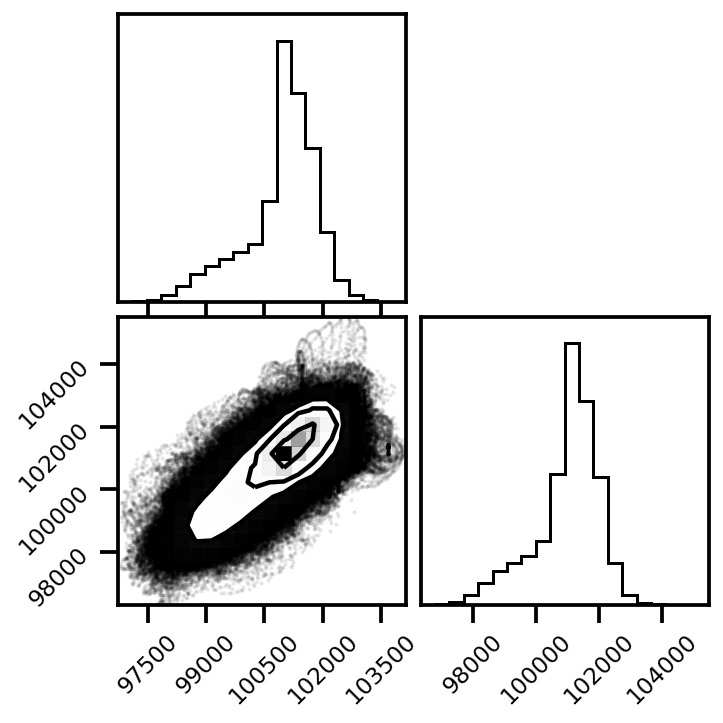

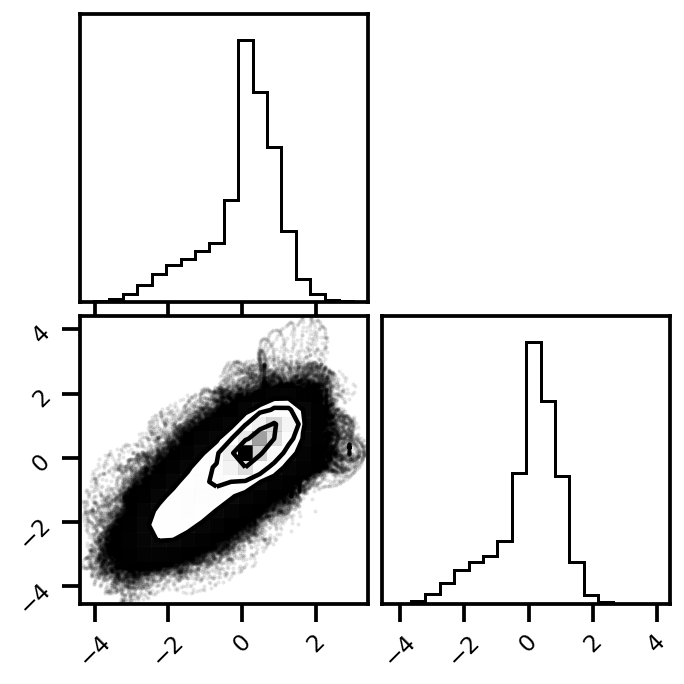

In [77]:
from mutual_info.mutual_info import mutual_information as mi_mutual_info
from npeet.entropy_estimators import mi as npeet_mutual_info

model_ids = final_ds.coords["model_id"].values

imodel_stats = {"model_0": model_ids[0], "model_1": model_ids[1]}


# select model
ids = final_ds.sel(model_id=[imodel_pair[0], imodel_pair[1]]).psl.values

x = np.reshape(ids[0], (n_lat * n_lon * n_time))
y = np.reshape(ids[1], (n_lat * n_lon * n_time))
corner.corner(np.vstack((x,y)).T)
plt.show()

# Transform Data
transform = "standardize"
x = transform_data(x, transform=transform)
y = transform_data(y, transform=transform)
corner.corner(np.hstack((x,y)))
plt.show()

#### Pearson Correlation

In [119]:
from src.models.univariate import pearson


t0 = time.time()
            
# res = RV().statistic(x=x.copy()[:1_000], y=y.copy()[:1_000])
res = pearson(x.copy().ravel(), y.copy().ravel())

print(f"Pearson:  {res['pearson']:.4f} | Time: {time.time()-t0:.4f} secs")

Pearson:  0.7938 | Time: 0.0620 secs


#### RV Coefficient

In [120]:
from hyppo.independence import RV

t0 = time.time()
            
# res = RV().statistic(x=x.copy()[:1_000], y=y.copy()[:1_000])
res = RV().statistic(x=x.copy(), y=y.copy())

print(f"RV Coeffiecient (HSIC+Linear):  {res:.4f} | Time: {time.time()-t0:.4f} secs")

RV Coeffiecient (HSIC+Linear):  0.6301 | Time: 0.0158 secs


#### Canonical Correlation Analysis (CCA)

In [121]:
from hyppo.independence import CCA

t0 = time.time()
            
# res = RV().statistic(x=x.copy()[:1_000], y=y.copy()[:1_000])
res = CCA().statistic(x=x.copy(), y=y.copy())

print(f"CCA:  {res:.4f} | Time: {time.time()-t0:.4f} secs")

CCA:  0.6301 | Time: 0.0293 secs


### Information Theory Metrics

#### Gaussian Assumption

In [123]:
from pysim.information.gaussian import gauss_entropy_multi
from pysim.information.mutual import multivariate_mutual_information

t0 = time.time()
res = multivariate_mutual_information(X=x.copy(), Y=y.copy(), f=gauss_entropy_multi)
print(f"Gaussian: {res['mi']:.4f} | Time: {time.time()-t0:.4f} secs")

Gaussian: 0.4973 | Time: 0.1128 secs


#### KNN MI (Neighbours)

In [122]:
from mutual_info.mutual_info import mutual_information as mi_mutual_info


t0 = time.time()
            
res = mi_mutual_info((x.copy(), y.copy()), k=10, )

print(f"KNN (Neighbours):  {res:.4f} | Time: {time.time()-t0:.4f} secs")

KNN (Neighbours):  0.7360 | Time: 28.1400 secs


#### KNN MI (Epsilon)

In [86]:
from pysim.information.knn import knn_entropy_npeet

t0 = time.time()
            
res = npeet_mutual_info(x=x.copy(), y=y.copy(), k=10, base=np.e,)

print(f"KNN (Neighbours):  {res:.4f} | Time: {time.time()-t0:.4f} secs")

KNN (Neighbours):  0.6288 | Time: 26.9983 secs


#### HSIC (Linear aka RV)

In [25]:
from hyppo.independence import Hsic

t0 = time.time()
hsic_model = Hsic(compute_kernel="linear")
res = hsic_model.statistic(x=x.copy()[:1_000], y=y.copy()[:1_000])

print(f"HSIC (Linear):  {res:.4f} | Time: {time.time()-t0:.4f} secs")

HSIC (Linear):  0.7720 | Time: 0.4100 secs


#### HSIC (Gaussian)

In [109]:
from hyppo.independence import Hsic

t0 = time.time()
            
res = Hsic(compute_kernel="gaussian").statistic(x=x.copy()[:1_000], y=y.copy()[:1_000])

print(f"HSIC (Gaussian):  {res:.4f} | Time: {time.time()-t0:.4f} secs")

HSIC (Gaussian):  0.5863 | Time: 0.1364 secs


#### Distance Correlation

In [104]:
from hyppo.independence import Dcorr

t0 = time.time()
            
res = Dcorr(compute_distance="euclidean").statistic(x=x.copy()[:1_000], y=y.copy()[:1_000])
# res = Dcorr(compute_distance="euclidean").statistic(x=x.copy(), y=y.copy())

print(f"DCorr (euclidean):  {res:.4f} | Time: {time.time()-t0:.4f} secs")

DCorr (euclidean):  0.7309 | Time: 0.0785 secs


#### MGC

In [107]:
from hyppo.independence import MGC

t0 = time.time()
            
res = MGC(compute_distance="euclidean").statistic(x=x.copy()[:1_000], y=y.copy()[:1_000])
# res = Dcorr(compute_distance="euclidean").statistic(x=x.copy(), y=y.copy())

print(f"MGC (euclidean):  {res:.4f} | Time: {time.time()-t0:.4f} secs")

MGC (euclidean):  0.7309 | Time: 0.4132 secs


#### MMD

In [128]:
from hyppo.ksample import MMD

t0 = time.time()
            
res = MMD(compute_kernel="gaussian").statistic(x=x.copy()[:1_000], y=y.copy()[:1_000])
# res = MMD(compute_kernel="gaussian").statistic(x=x.copy(), y=y.copy())

print(f"MMD (euclidean):  {res:.4f} | Time: {time.time()-t0:.4f} secs")

MMD (euclidean):  0.0693 | Time: 0.5511 secs


#### Energy

In [131]:
from hyppo.ksample import Energy

t0 = time.time()
            
res = Energy(compute_distance="euclidean").statistic(x=x.copy()[:1_000], y=y.copy()[:1_000])
# res = Energy(compute_distance="euclidean").statistic(x=x.copy(), y=y.copy())

print(f"Energy Distance (euclidean):  {res:.4f} | Time: {time.time()-t0:.4f} secs")

Energy Distance (euclidean):  0.0076 | Time: 0.0637 secs


## Demo Experiment

In [97]:
# =====================
# PEARSON CORRELATION
# =====================

import pandas as pd


from scipy.stats import pearsonr

# get all model IDS
EXPERIMENT = "univariate"

import tqdm
import numpy as np
import time


all_stats = pd.DataFrame()
model_ids = final_ds.coords["model_id"].values
sym_pairs = [pair for pair in itertools.combinations(model_ids, 2)]

with tqdm.tqdm(sym_pairs) as pbar:

    for i, imodel_pair in enumerate(pbar):
        
        imodel_stats = {"model_0": imodel_pair[0], "model_1": imodel_pair[1]}

        pbar.set_description(f"Model 1: {imodel_pair[0]}, Model 2: {imodel_pair[1]}")

        # select model
        ids = final_ds.sel(model_id=[imodel_pair[0], imodel_pair[1]]).psl.values


        # calculate pearson correlation
#         pbar.set_description(f"Calculating Correlation...")
        
#         x = np.reshape(ids[0], (n_lat * n_lon * n_time))
#         y = np.reshape(ids[1], (n_lat * n_lon * n_time))
        
        if EXPERIMENT == "univariate":

            # calculate pearson correlation
            pbar.set_description(f"Calculating Univariate Stats...")

            x = np.reshape(ids[0], (n_lat * n_lon * n_time))
            y = np.reshape(ids[1], (n_lat * n_lon * n_time))
            
            # Transform Data
            transform = "standardize"
            x = transform_data(x, transform=transform)
            y = transform_data(y, transform=transform)
            
            uni_stats = get_univariate_stats(x, y, model="gaussian_mi")
            imodel_stats = {**imodel_stats, **uni_stats}
            
            uni_stats = get_univariate_stats(x, y, model="knn_eps_mi")
            imodel_stats = {**imodel_stats, **uni_stats}

#             print(imodel_stats)
            
        elif EXPERIMENT == "multivariate":

            # calculate pearson correlation
            pbar.set_description(f"Calculating Multivariate Stats...")

            x = np.reshape(ids[0], (n_lat * n_lon, n_time))
            y = np.reshape(ids[1], (n_lat * n_lon, n_time))

#             multi_stats = multivariate_stats(x, y)
            
#             imodel_stats = {**imodel_stats, **multi_stats}
            
#             # calculate pearson correlation
#             pbar.set_description(f"Calculating Info Stats (RBIG)...")
            
#             t0 = time.time()
#             mi_XY_rbig = rbig_mutual_info(
#                 X=jnp.array(x, jnp.float32).block_until_ready(),
#                 Y=jnp.array(y, jnp.float32).block_until_ready(),
#                 zero_tolerance=30,
#             )
            
#             imodel_stats["mi_X"] = np.array(mi_XY_rbig.mi_X)
#             imodel_stats["mi_Y"] = np.array(mi_XY_rbig.mi_Y)
#             imodel_stats["mi_XY"] = np.array(mi_XY_rbig.mi_XY)
#             imodel_stats["mi_time"] = time.time() - t0

            
            pbar.set_description(f"Calculating Info Stats (KNN)...")
            t0 = time.time()
            mi = knn_mi(x, y, None, None, 3)
            
            imodel_stats["mi_xy_knn"] = mi
            imodel_stats["mi_time"] = time.time() - t0
            
#         prs_r = pearson(x, y)
        
#         imodel_stats = {**imodel_stats, **prs_r}
        
        
#         X = np.reshape(ids[0], (n_lat * n_lon, n_time))
#         Y = np.reshape(ids[1], (n_lat * n_lon, n_time))
        
#         # calculate pearson correlation
#         pbar.set_description(f"Calculating Pearson (per dim)...")

#         prs_d_r = pearson_dim(X, Y)
        
#         imodel_stats = {**imodel_stats, **prs_d_r}
        
#         # calculate pearson correlation
#         pbar.set_description(f"Calculating RV Coeff ...")
        
#         X = np.reshape(ids[0], (n_lat * n_lon, n_time))
#         Y = np.reshape(ids[1], (n_lat * n_lon, n_time))
#         rv = rv_coefficient(X, Y)
        
#         imodel_stats = {**imodel_stats, **rv}
        
        
#         # calculate pearson correlation
#         pbar.set_description(f"Calculating nHSIC Coeff...")
        
#         nhsic = cka_coefficient(X, Y)
        
#         imodel_stats = {**imodel_stats, **nhsic}
                
#         # calculate cka (nystrom)
#         pbar.set_description(f"Calculating rand nHSIC (nystroem) Coeff...")
        
#         rhsic_nys = cka_coefficient_nystroem(X, Y, )
        
#         imodel_stats = {**imodel_stats, **rhsic_nys}
        
#         # calculate cka (rff)
#         pbar.set_description(f"Calculating rand nHSIC (rff) Coeff...")
        
#         rhsic_rff = cka_coefficient_rff(X, Y)
        
#         imodel_stats = {**imodel_stats, **rhsic_rff}
        
        
        all_stats = pd.concat([all_stats, pd.DataFrame(imodel_stats, index=[i])], axis=0)
#         break
        
all_stats.head()

Calculating Univariate Stats...: 100%|██████████| 78/78 [34:43<00:00, 26.71s/it]             


,model_0,model_1,gaussian_mi_time,gaussian_mi,gaussian_H_XY,gaussian_H_X,gaussian_H_Y,knn_eps_mi,knn_eps_time
0,giss_e2_h_cc,mpi_esm_lr,0.110556,0.497295,2.340582,1.418939,1.418939,0.628821,26.989177
1,giss_e2_h_cc,bnu_esm,0.070250,0.447697,2.390181,1.418939,1.418939,0.644825,29.660962
2,giss_e2_h_cc,access1_0,0.067667,0.528875,2.309003,1.418939,1.418939,0.769131,25.808990
3,giss_e2_h_cc,access1_3,0.068122,0.546345,2.291533,1.418939,1.418939,0.760204,26.464098
4,giss_e2_h_cc,noresm1_m,0.067620,0.469081,2.368797,1.418939,1.418939,0.701579,26.173789


In [67]:
from src.visualization.climate.utils import get_pivot_df, plot_dendrogram, plot_heatmap


In [69]:
df_gauss = get_pivot_df(all_stats, "gaussian_mi")
df_rv = get_pivot_df(all_stats, "rv_coeff")

## Visualization

### Heatmap

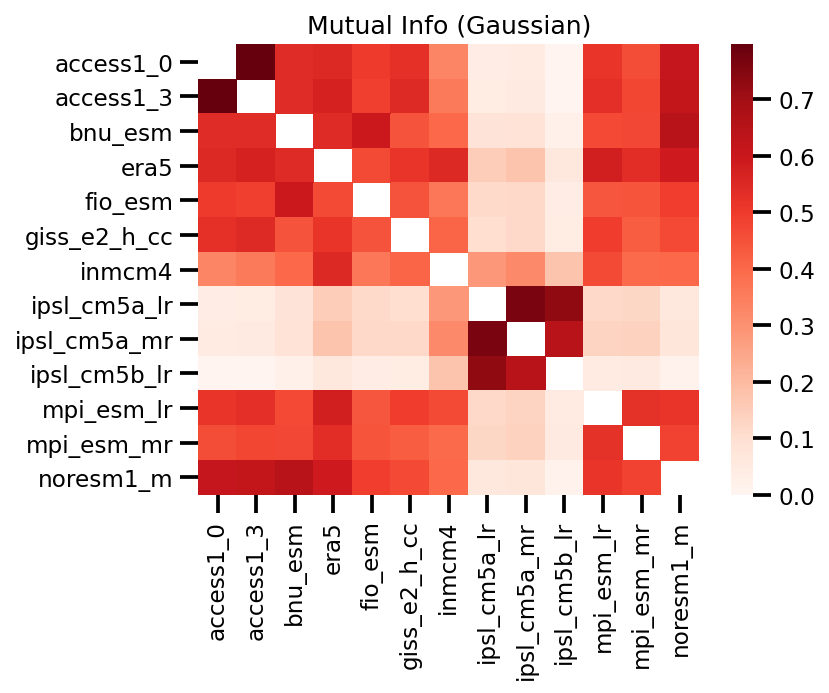

In [35]:
plt_kwargs = {"vmin": 0, "cmap": "Reds"}

fig, ax = plt.subplots(figsize=(6, 5))
ax = plot_heatmap(df_gauss, ax, **plt_kwargs)
ax.set(title="Mutual Info (Gaussian)")
plt.tight_layout()

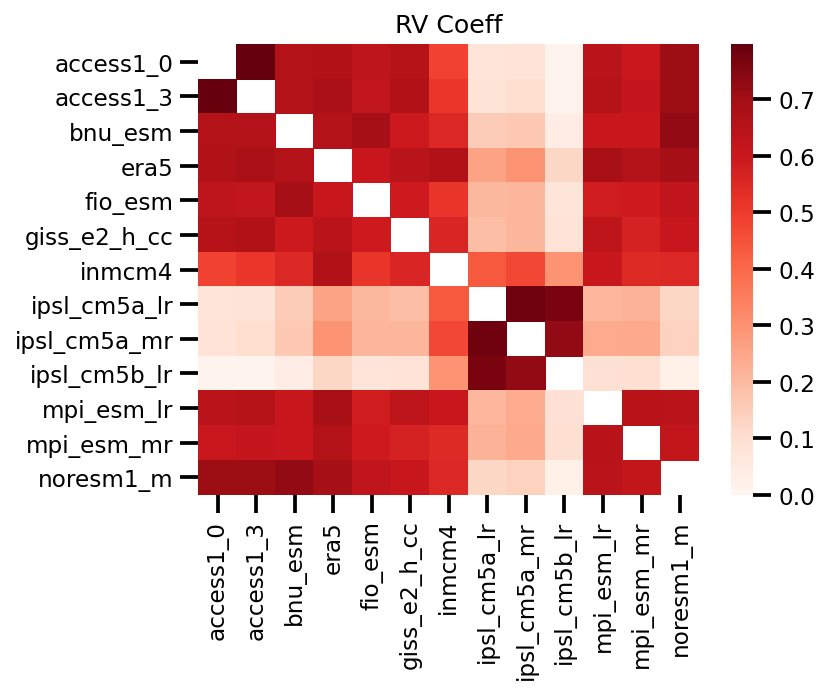

In [70]:
plt_kwargs = {"vmin": 0, "cmap": "Reds"}

fig, ax = plt.subplots(figsize=(6, 5))
ax = plot_heatmap(df_rv, ax, **plt_kwargs)
ax.set(title="RV Coeff")
plt.tight_layout()

### Dendrogram

In [40]:
cmip_model_names = {
    "access1_0": "ACCESS-1.0",
    "access1_3": "ACCESS-3.0",
    "bnu_esm": "BNU-ESM",
    "era5": "ERA5",
    "inmcm4": "INMCM4",
    "ipsl_cm5a_lr": "IPSL-CM5A-LR",
    "ipsl_cm5b_lr": "IPSL-CM5B-LR",
    "ipsl_cm5a_mr": "IPSL-CM5A-MR",
    "mpi_esm_lr": "MPI-ESM-LR",
    "mpi_esm_mr": "MPI-ESM-MR",
    "giss_e2_h_cc": "GISS-E2-H-CC",
    "fio_esm": "FIO-ESM",
    "noresm1_m": "NORESM1-M",
    "ccsm4": "CCSM4",
}

stats_model_names = {
    "pearson": "Pearson Coeff",
    "pearson_d": "Pearson Coeff (Dim)",
    "spearman": "Spearman Coeff",
    "kendall": "Kendall-Tau Coeff",
    "rv_coeff": "RV Coeff",
    "cka_coeff": "nHSIC",
    "rcka_coeff_nys": "nHSIC (Nystroem)",
    "rcka_coeff_rff": "nHSIC (RFF)",
    "mi_xy": "MI (RBIG)",
    "knn_nbs_mi": "MI (k-NN)",
    "knn_eps_mi": "MI (Epsilon-NN",
    "gaussian_mi": "MI (Gaussian)",
    "cca": "CCA",
    "nhsic_lin": "nHSIC (Linear)",
    "nhsic_rbf": "nHSIC (RBF)",
    "mmd_lin": "MMD (Linear)",
    "mmd_rbf": "MMD (RBF)",
    "mgc": "MGC",
    "dcorr": "Distance Corr.",
    "energy": "Energy Distance",
}

In [60]:
linkage

array([[ 0.        ,  1.        ,  0.20314376,  2.        ],
       [ 7.        ,  8.        ,  0.23642358,  2.        ],
       [ 9.        , 14.        ,  0.35080446,  3.        ],
       [12.        ,  2.        ,  0.35161097,  2.        ],
       [ 3.        , 10.        ,  0.41953652,  2.        ],
       [13.        , 16.        ,  0.45924265,  4.        ],
       [11.        , 17.        ,  0.4767464 ,  3.        ],
       [18.        ,  4.        ,  0.50940204,  5.        ],
       [ 5.        , 20.        ,  0.55437134,  6.        ],
       [19.        , 21.        ,  0.57627409,  9.        ],
       [ 6.        , 22.        ,  0.66858304, 10.        ],
       [15.        , 23.        ,  0.99527563, 13.        ]])

In [93]:
linkage.shape, order.shape, idx.shape, idx[1:].shape

((12, 4), (13,), (13,), (12,))

In [95]:
linkage[idx[:-1]].shape

(12, 4)

In [79]:
idx = np.argsort(order)

In [81]:
idx, order

(array([ 9, 10, 11,  5,  8,  7,  3,  1,  2,  0,  6,  4, 12]),
 array([ 9,  7,  8,  6, 11,  3, 10,  5,  4,  0,  1,  2, 12], dtype=int32))

(12, 4) (13,)


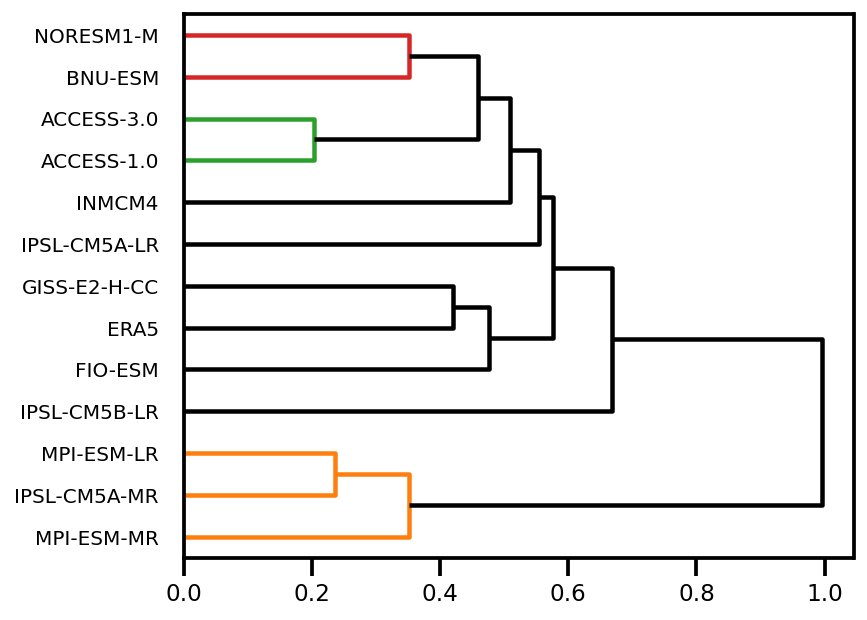

In [96]:
fig, ax = plt.subplots(figsize=(6, 5))

names = [i for i in cmip_model_names.values()]

# normalize by the largest value
max_value = max(df_gauss.max().max(), 1)

# calculate the distance matrix
pdist = max_value - np.abs(df_gauss.values)
pdist = pdist[np.triu_indices_from(pdist, k=1)]
linkage = spc.linkage(pdist, method="complete", optimal_ordering=False)
order = spc.leaves_list(linkage)
spc.dendrogram(
    linkage,
    above_threshold_color="k",
    color_threshold=0.4,
    orientation="right",
    leaf_label_func=lambda i: names[i],
    leaf_font_size=10,
    leaf_rotation=0,
    ax=ax,
    distance_sort=False
)
plt.show()

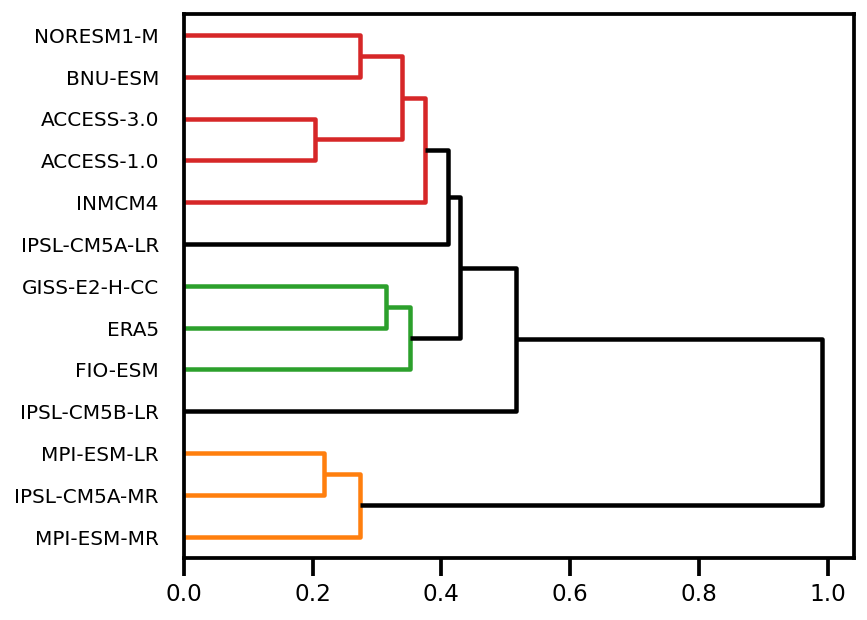

In [74]:
fig, ax = plt.subplots(figsize=(6, 5))

names = [i for i in cmip_model_names.values()]

# normalize by the largest value
max_value = max(df_rv.max().max(), 1)

# calculate the distance matrix
pdist = max_value - np.abs(df_rv.values)
pdist = pdist[np.triu_indices_from(pdist, k=1)]
linkage = spc.linkage(pdist, method="complete", optimal_ordering=False)
order = spc.leaves_list(linkage)
spc.dendrogram(
    linkage,
    above_threshold_color="k",
    color_threshold=0.4,
    orientation="right",
    leaf_label_func=lambda i: names[i],
    leaf_font_size=10,
    leaf_rotation=0,
    ax=ax,
    distance_sort=False
)
plt.show()

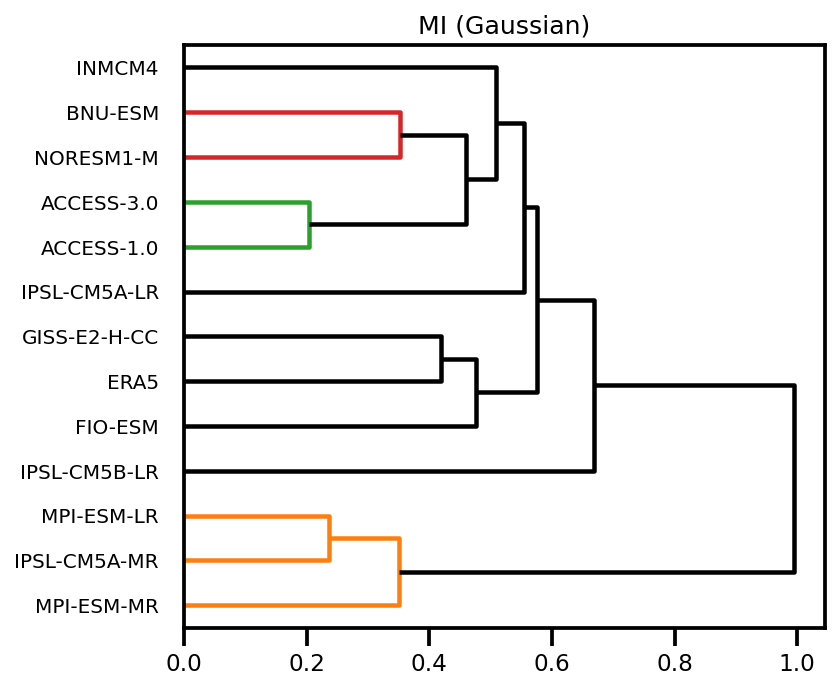

In [42]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = plot_dendrogram(df_, ax, cmip_model_names)
ax.set(title=stats_model_names["gaussian_mi"])
plt.tight_layout()


In [36]:
import scipy.cluster.hierarchy as spc
pdist = max(t.max().max(), 1) - np.abs(t.values)
pdist = pdist[np.triu_indices_from(pdist, k=1)]
linkage = spc.linkage(pdist, method="complete", optimal_ordering=True)
order = spc.leaves_list(linkage)

name_corrections = {
    "access1_0": "ACCESS-1.0",
    "access1_3": "ACCESS-3.0",
    "bnu_esm": "BNU-ESM",
    "era5": "ERA5",
    "inmcm4": "INMCM4",
    "ipsl_cm5a_lr": "IPSL-CM5A-LR",
    "ipsl_cm5b_lr": "IPSL-CM5B-LR",
    "ipsl_cm5a_mr": "IPSL-CM5A-MR",
    "mpi_esm_lr": "MPI-ESM-LR",
    "mpi_esm_mr": "MPI-ESM-MR",
    "giss_e2_h_cc": "GISS-E2-H-CC",
    "fio_esm": "FIO-ESM",
    "noresm1_m": "NORESM1-M",
    "ccsm4": "CCSM4",
}
names = [i for i in name_corrections.values()]
# def names(i):
#     return name_corrections

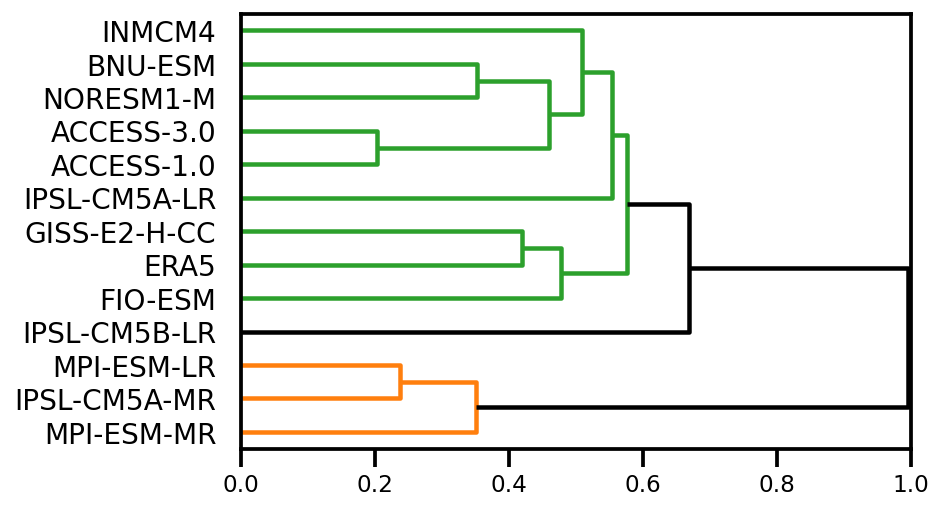

In [37]:
fig, ax = plt.subplots()
d = spc.dendrogram(
        linkage,
        above_threshold_color="k",
        color_threshold=0.6,
        orientation="right",
        leaf_label_func=lambda i: names[i],
        leaf_font_size=14,
        leaf_rotation=0,
    ax=ax
    )
ax.set_xlim([0.0, 1.0])
plt.show()

In [ ]:
all_pairs = [pair for pair in itertools.product(model_ids, model_ids)]

grid_size =

for im, jm in all_pairs

In [ ]:
from src.models.univariate import univariate_stats, pearson
from src.models.kernels import rv_coefficient, cka_coefficient

In [47]:
model_ids

array(['inmcm4', 'bnu_esm', 'ipsl_cm5b_lr', 'mpi_esm_mr', 'access1_0',
       'mpi_esm_lr', 'era5'], dtype='<U12')

In [61]:
[pair for pair in itertools.product(model_ids, model_ids)]

[('giss_e2_h_cc', 'giss_e2_h_cc'),
 ('giss_e2_h_cc', 'mpi_esm_lr'),
 ('giss_e2_h_cc', 'bnu_esm'),
 ('giss_e2_h_cc', 'access1_0'),
 ('giss_e2_h_cc', 'access1_3'),
 ('giss_e2_h_cc', 'noresm1_m'),
 ('giss_e2_h_cc', 'mpi_esm_mr'),
 ('giss_e2_h_cc', 'ipsl_cm5b_lr'),
 ('giss_e2_h_cc', 'ccsm4'),
 ('giss_e2_h_cc', 'ipsl_cm5a_mr'),
 ('giss_e2_h_cc', 'inmcm4'),
 ('giss_e2_h_cc', 'fio_esm'),
 ('giss_e2_h_cc', 'ipsl_cm5a_lr'),
 ('giss_e2_h_cc', 'era5'),
 ('mpi_esm_lr', 'giss_e2_h_cc'),
 ('mpi_esm_lr', 'mpi_esm_lr'),
 ('mpi_esm_lr', 'bnu_esm'),
 ('mpi_esm_lr', 'access1_0'),
 ('mpi_esm_lr', 'access1_3'),
 ('mpi_esm_lr', 'noresm1_m'),
 ('mpi_esm_lr', 'mpi_esm_mr'),
 ('mpi_esm_lr', 'ipsl_cm5b_lr'),
 ('mpi_esm_lr', 'ccsm4'),
 ('mpi_esm_lr', 'ipsl_cm5a_mr'),
 ('mpi_esm_lr', 'inmcm4'),
 ('mpi_esm_lr', 'fio_esm'),
 ('mpi_esm_lr', 'ipsl_cm5a_lr'),
 ('mpi_esm_lr', 'era5'),
 ('bnu_esm', 'giss_e2_h_cc'),
 ('bnu_esm', 'mpi_esm_lr'),
 ('bnu_esm', 'bnu_esm'),
 ('bnu_esm', 'access1_0'),
 ('bnu_esm', 'access1_3'),

In [90]:
import itertools
all_pairs = [pair for pair in itertools.product(model_ids, model_ids)]
inv_pairs = map(lambda x: tuple(reversed(x)), all_pairs)

all_pairs

[('inmcm4', 'inmcm4'),
 ('inmcm4', 'bnu_esm'),
 ('inmcm4', 'ipsl_cm5b_lr'),
 ('inmcm4', 'mpi_esm_mr'),
 ('inmcm4', 'access1_0'),
 ('inmcm4', 'mpi_esm_lr'),
 ('inmcm4', 'era5'),
 ('bnu_esm', 'inmcm4'),
 ('bnu_esm', 'bnu_esm'),
 ('bnu_esm', 'ipsl_cm5b_lr'),
 ('bnu_esm', 'mpi_esm_mr'),
 ('bnu_esm', 'access1_0'),
 ('bnu_esm', 'mpi_esm_lr'),
 ('bnu_esm', 'era5'),
 ('ipsl_cm5b_lr', 'inmcm4'),
 ('ipsl_cm5b_lr', 'bnu_esm'),
 ('ipsl_cm5b_lr', 'ipsl_cm5b_lr'),
 ('ipsl_cm5b_lr', 'mpi_esm_mr'),
 ('ipsl_cm5b_lr', 'access1_0'),
 ('ipsl_cm5b_lr', 'mpi_esm_lr'),
 ('ipsl_cm5b_lr', 'era5'),
 ('mpi_esm_mr', 'inmcm4'),
 ('mpi_esm_mr', 'bnu_esm'),
 ('mpi_esm_mr', 'ipsl_cm5b_lr'),
 ('mpi_esm_mr', 'mpi_esm_mr'),
 ('mpi_esm_mr', 'access1_0'),
 ('mpi_esm_mr', 'mpi_esm_lr'),
 ('mpi_esm_mr', 'era5'),
 ('access1_0', 'inmcm4'),
 ('access1_0', 'bnu_esm'),
 ('access1_0', 'ipsl_cm5b_lr'),
 ('access1_0', 'mpi_esm_mr'),
 ('access1_0', 'access1_0'),
 ('access1_0', 'mpi_esm_lr'),
 ('access1_0', 'era5'),
 ('mpi_esm_lr', '

In [73]:
len(all_pairs), len(sym_pairs)

(49, 21)

In [53]:
('era5', 'inmcm4') != tuple(reversed(('inmcm4', 'era5')))

False

In [52]:
reversed(('inmcm4', 'era5'))